In [172]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
import gammapy_fct as gf
import pandas as pd
import numpy as np
from copy import deepcopy
import astropy
import gammapy
from astropy.table import Table, vstack
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.data import DataStore, EventList
from gammapy.irf.effective_area import EffectiveAreaTable2D
from gammapy.irf.energy_dispersion import EnergyDispersion2D
from gammapy.irf.psf_gauss import EnergyDependentMultiGaussPSF
from gammapy.irf import EffectiveAreaTable2D, load_cta_irfs, Background2D

gammapy.data.HDUIndexTable.VALID_HDU_CLASS
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.data import DataStore, Observation
from gammapy.datasets import (
    Dataset,
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    MapDataset,
    MapDatasetOnOff,
    SpectrumDatasetOnOff
)
from gammapy.modeling.models import *
from gammapy.modeling.models import FoVBackgroundModel
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom, Map, RegionNDMap
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
    ReflectedRegionsFinder,
    FoVBackgroundMaker
    
)
from astropy.io import fits
from gammapy.estimators import *
from gammapy.estimators.utils import find_peaks
from gammapy.visualization import plot_spectrum_datasets_off_regions

from gammapy.utils.regions import make_region
from itertools import combinations
from gammapy.visualization.utils import plot_contour_line

CPU times: user 5.54 ms, sys: 18.7 ms, total: 24.3 ms
Wall time: 33 ms


In [173]:

data_store = DataStore.from_dir("/Users/cedrickperron/GAMMAPY/LS5039")
s = data_store.hdu_table.read("/Users/cedrickperron/GAMMAPY/LS5039/hdu-index.fits.gz")
OBS_table = data_store.obs_table.read("/Users/cedrickperron/GAMMAPY/LS5039/obs-index.fits.gz")
# Changing the path to the fits files in the HDU_table
s.remove_column("FILE_DIR")
s.add_column("/Users/cedrickperron/GAMMAPY/LS5039", name="FILE_DIR")



In [174]:
data_store.hdu_table = s
hdu_table = data_store.hdu_table
obs_table = data_store.obs_table


data_store.hdu_table
obs_id = data_store.obs_table["OBS_ID"]

#print(obs_id)

# Note NO HDU of HDU_TYPE = bkg. Write print(hdu_table) and you will see that there is no bkg.
observations = data_store.get_observations(obs_id)
hdu_table = data_store.hdu_table
hdu_table

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_NAME,HDU_NAME,FILE_DIR
int64,bytes6,bytes10,bytes54,bytes20,str35
69054,events,events,69054.anasum.fits,EVENTS,/Users/cedrickperron/GAMMAPY/LS5039
69054,gti,gti,69054.anasum.fits,GTI,/Users/cedrickperron/GAMMAPY/LS5039
69054,aeff,aeff_2d,69054.anasum.fits,EFFECTIVE AREA,/Users/cedrickperron/GAMMAPY/LS5039
69054,edisp,edisp_2d,69054.anasum.fits,ENERGY DISPERSION,/Users/cedrickperron/GAMMAPY/LS5039
69054,psf,psf_table,69054.anasum.fits,PSF,/Users/cedrickperron/GAMMAPY/LS5039
69054,bkg,bkg_2d,69054.anasum.fits,BKG,/Users/cedrickperron/GAMMAPY/LS5039
69123,events,events,69123.anasum.fits,EVENTS,/Users/cedrickperron/GAMMAPY/LS5039
69123,gti,gti,69123.anasum.fits,GTI,/Users/cedrickperron/GAMMAPY/LS5039
69123,aeff,aeff_2d,69123.anasum.fits,EFFECTIVE AREA,/Users/cedrickperron/GAMMAPY/LS5039


In [175]:
obs_table

OBS_ID,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,N_TELS,TELLIST
,deg,deg,deg,deg,deg,s,s,,s,s,,
int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes20
69054,276.56342,-14.348431,53.779232,36.220768,215.54797,2049.078,1860.2681,0.9078562,263470850.0,263472900.0,4,"T1,T2,T3,T4"
69123,276.562,-15.34843,48.47988,41.52012,195.95264,1802.6912,1622.2295,0.89989316,263811630.0,263813440.0,4,"T1,T2,T3,T4"
69187,277.08,-14.848524,46.666584,43.333416,185.3455,1802.7084,1656.9017,0.919118,264154430.0,264156240.0,4,"T1,T2,T3,T4"
69188,276.04544,-14.84718,48.08042,41.91958,196.68805,1802.7072,1666.6135,0.924506,264156300.0,264158110.0,4,"T1,T2,T3,T4"
69202,276.56342,-14.348431,46.311962,43.688038,187.28421,1802.6796,1594.925,0.88475245,264240820.0,264242610.0,4,"T1,T2,T3,T4"
69203,276.562,-15.34843,48.71455,41.28545,197.1719,1802.7202,1587.1078,0.88039607,264242670.0,264244480.0,4,"T1,T2,T3,T4"
73193,276.04544,-14.847137,46.543064,43.456936,177.73186,1321.5967,1131.7001,0.8563127,291467100.0,291468400.0,4,"T1,T2,T3,T4"
73213,276.56345,-14.348431,46.258514,43.741486,173.92455,2100.5056,1819.273,0.866112,291552300.0,291554400.0,4,"T1,T2,T3,T4"


In [176]:
target_position=SkyCoord("18h26m15s" , "-14d49m30s", unit="deg",frame="icrs")
print(target_position)
on_radius=Angle("0.089 deg")
on_region= CircleSkyRegion(center=target_position,radius=on_radius)

<SkyCoord (ICRS): (ra, dec) in deg
    (276.5625, -14.825)>


In [220]:
energy_axis = MapAxis.from_energy_bounds(0.400, 20, 15, unit= "TeV", name="energy")
energy_axis_true = MapAxis.from_energy_bounds(0.200, 30, 20, unit= "TeV", name="energy_true")




In [221]:
%%cache
#TODO Take the same exclusion region as Tobias, because you end up with having -600 excess... 
# Exclusion Region

df=pd.read_csv('./GAMMAPY/exclusion mask.csv', sep=',',header=None)
ra_list = list(df[0])
dec_list = list(df[1])
region_list = []
for ra, dec in zip(ra_list, dec_list):
    region_list.append(make_region(f"icrs;circle({ra}, {dec}, 0.35)"))
exclusion_mask=[]
def exclusion_mask(geom, center_region):
    geom_image = geom
    exclusion_mask=Map.from_geom(geom)
    if center_region not in region_list:
        region_list.append(center_region)
    exclusion_mask.data=geom.region_mask(region_list, inside=False)
    return exclusion_mask

# 0.089
geom = WcsGeom.create(skydir=target_position, binsz=0.02, width="7 deg", frame="galactic", axes=[energy_axis])
center_region = CircleSkyRegion(center=target_position, radius=0.35* u.deg)

exclusion_mask = exclusion_mask(geom, center_region)
exclusion_mask.sum_over_axes().plot(add_cbar=True)

UsageError: Cell magic `%%cache` not found.


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7ff8163e7dd8>)

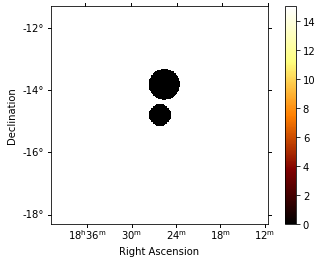

In [222]:
geom = WcsGeom.create(skydir=target_position, binsz=0.02, width="7 deg", proj="CAR", axes=[energy_axis])
geom_image = geom
hess_region = make_region("icrs;circle(276.421,-13.8389, 0.50)")
center_region = CircleSkyRegion(center=target_position, radius=0.35 * u.deg)
exclusion_mask=Map.from_geom(geom_image)
# Note Inside = True => Then all the regions outside will not have any pixels. False => Region inside have no pixel
exclusion_mask.data=geom_image.region_mask([hess_region, center_region], inside=False)
# No pixel => Energy => 0 (no signal)
exclusion_mask.sum_over_axes().plot(add_cbar=True)

In [223]:
# Dataset Maker
dataset_empty = MapDatasetOnOff.create(geom = geom, energy_axis_true=energy_axis_true, binsz_irf=0.25)

# Contains all the IRFs: aeff is included. No need to specify
dataset_maker = MapDatasetMaker(selection=["counts", "exposure", "edisp", "psf", "background"])
safe_mask_maker = SafeMaskMaker(methods=["aeff-default", "offset-max"], offset_max=1.75*u.deg, aeff_percent=10)

bkg_maker = FoVBackgroundMaker(method="scale", exclusion_mask=exclusion_mask)



In [224]:
%%time
count = 0
list_of_datasets = Datasets()
stacked = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true,binsz_irf=0.25, name=f"stacked")

for ind, obs in enumerate(observations):
    dataset = dataset_maker.run(dataset_empty.copy(name = f"{obs.obs_id}"), obs)
    dataset = safe_mask_maker.run(dataset, obs)
    dataset = bkg_maker.run(dataset, obs)
    #print(dataset)
    stacked.stack(dataset)
    print(count, dataset)
    list_of_datasets.append(dataset)
    count += 1
    


/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


0 MapDataset
----------

  Name                            : 69054 

  Total counts                    : 2105 
  Total background counts         : 1561.10
  Total excess counts             : 543.90

  Predicted counts                : 1972.01
  Predicted background counts     : 1972.01
  Predicted excess counts         : 0.00

  Exposure min                    : 6.04e+02 m2 s
  Exposure max                    : 7.07e+08 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 360690 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 23010.12

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 69054-bkg
    Datasets names            : ['69054']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.263              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


1 MapDataset
----------

  Name                            : 69123 

  Total counts                    : 1879 
  Total background counts         : 1373.29
  Total excess counts             : 505.71

  Predicted counts                : 1830.37
  Predicted background counts     : 1830.37
  Predicted excess counts         : 0.00

  Exposure min                    : 2.45e+04 m2 s
  Exposure max                    : 5.84e+08 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 360645 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 20545.73

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 69123-bkg
    Datasets names            : ['69123']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.333              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


2 MapDataset
----------

  Name                            : 69187 

  Total counts                    : 1461 
  Total background counts         : 1373.23
  Total excess counts             : 87.77

  Predicted counts                : 1391.51
  Predicted background counts     : 1391.51
  Predicted excess counts         : 0.00

  Exposure min                    : 4.88e+04 m2 s
  Exposure max                    : 5.71e+08 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 360600 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 16589.08

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 69187-bkg
    Datasets names            : ['69187']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.013              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


3 MapDataset
----------

  Name                            : 69188 

  Total counts                    : 1488 
  Total background counts         : 1373.30
  Total excess counts             : 114.70

  Predicted counts                : 1442.84
  Predicted background counts     : 1442.84
  Predicted excess counts         : 0.00

  Exposure min                    : 2.47e+04 m2 s
  Exposure max                    : 5.95e+08 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 360630 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17007.73

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 69188-bkg
    Datasets names            : ['69188']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.051              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


4 MapDataset
----------

  Name                            : 69202 

  Total counts                    : 2218 
  Total background counts         : 1373.38
  Total excess counts             : 844.62

  Predicted counts                : 2072.90
  Predicted background counts     : 2072.90
  Predicted excess counts         : 0.00

  Exposure min                    : 5.46e+04 m2 s
  Exposure max                    : 5.46e+08 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 360690 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 23480.34

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 69202-bkg
    Datasets names            : ['69202']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.509              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


5 MapDataset
----------

  Name                            : 69203 

  Total counts                    : 1993 
  Total background counts         : 1373.31
  Total excess counts             : 619.69

  Predicted counts                : 1954.18
  Predicted background counts     : 1954.18
  Predicted excess counts         : 0.00

  Exposure min                    : 2.38e+04 m2 s
  Exposure max                    : 5.85e+08 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 360645 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 21659.12

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 69203-bkg
    Datasets names            : ['69203']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.423              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


6 MapDataset
----------

  Name                            : 73193 

  Total counts                    : 1581 
  Total background counts         : 1006.81
  Total excess counts             : 574.19

  Predicted counts                : 1548.30
  Predicted background counts     : 1548.30
  Predicted excess counts         : 0.00

  Exposure min                    : 1.45e+05 m2 s
  Exposure max                    : 3.77e+08 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 360645 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17830.69

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 73193-bkg
    Datasets names            : ['73193']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.538              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


7 MapDataset
----------

  Name                            : 73213 

  Total counts                    : 2397 
  Total background counts         : 1600.29
  Total excess counts             : 796.71

  Predicted counts                : 2313.39
  Predicted background counts     : 2313.39
  Predicted excess counts         : 0.00

  Exposure min                    : 1.11e+05 m2 s
  Exposure max                    : 6.05e+08 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 360690 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 25156.95

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 73213-bkg
    Datasets names            : ['73213']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.446              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


8 MapDataset
----------

  Name                            : 73234 

  Total counts                    : 1069 
  Total background counts         : 777.13
  Total excess counts             : 291.87

  Predicted counts                : 1022.82
  Predicted background counts     : 1022.82
  Predicted excess counts         : 0.00

  Exposure min                    : 1.03e+05 m2 s
  Exposure max                    : 2.97e+08 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 360645 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12934.62

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 73234-bkg
    Datasets names            : ['73234']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.316              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


9 MapDataset
----------

  Name                            : 73300 

  Total counts                    : 1735 
  Total background counts         : 1371.33
  Total excess counts             : 363.67

  Predicted counts                : 1665.67
  Predicted background counts     : 1665.67
  Predicted excess counts         : 0.00

  Exposure min                    : 1.29e+05 m2 s
  Exposure max                    : 5.34e+08 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 360585 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19245.25

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 73300-bkg
    Datasets names            : ['73300']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.215              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


10 MapDataset
----------

  Name                            : 73317 

  Total counts                    : 1749 
  Total background counts         : 1379.79
  Total excess counts             : 369.21

  Predicted counts                : 1673.46
  Predicted background counts     : 1673.46
  Predicted excess counts         : 0.00

  Exposure min                    : 1.29e+05 m2 s
  Exposure max                    : 5.36e+08 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 360645 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19461.56

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 73317-bkg
    Datasets names            : ['73317']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.213              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


11 MapDataset
----------

  Name                            : 73335 

  Total counts                    : 1856 
  Total background counts         : 1325.36
  Total excess counts             : 530.64

  Predicted counts                : 1754.99
  Predicted background counts     : 1754.99
  Predicted excess counts         : 0.00

  Exposure min                    : 1.45e+05 m2 s
  Exposure max                    : 5.02e+08 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 360690 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 20388.95

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 73335-bkg
    Datasets names            : ['73335']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.324              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


12 MapDataset
----------

  Name                            : 73356 

  Total counts                    : 317 
  Total background counts         : 230.41
  Total excess counts             : 86.59

  Predicted counts                : 313.43
  Predicted background counts     : 313.43
  Predicted excess counts         : 0.00

  Exposure min                    : 1.42e+04 m2 s
  Exposure max                    : 8.98e+07 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 360645 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 4601.79

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 73356-bkg
    Datasets names            : ['73356']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.360              
      tilt         (frozen)   :  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


13 MapDataset
----------

  Name                            : 73357 

  Total counts                    : 1557 
  Total background counts         : 1245.43
  Total excess counts             : 311.57

  Predicted counts                : 1502.44
  Predicted background counts     : 1502.44
  Predicted excess counts         : 0.00

  Exposure min                    : 1.20e+05 m2 s
  Exposure max                    : 4.74e+08 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 360645 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17656.70

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 73357-bkg
    Datasets names            : ['73357']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.206              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


14 MapDataset
----------

  Name                            : 73370 

  Total counts                    : 1559 
  Total background counts         : 1371.36
  Total excess counts             : 187.64

  Predicted counts                : 1462.93
  Predicted background counts     : 1462.93
  Predicted excess counts         : 0.00

  Exposure min                    : 1.54e+05 m2 s
  Exposure max                    : 5.24e+08 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 360585 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17626.87

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 73370-bkg
    Datasets names            : ['73370']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.067              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


15 MapDataset
----------

  Name                            : 73390 

  Total counts                    : 1669 
  Total background counts         : 1371.48
  Total excess counts             : 297.52

  Predicted counts                : 1603.92
  Predicted background counts     : 1603.92
  Predicted excess counts         : 0.00

  Exposure min                    : 9.69e+04 m2 s
  Exposure max                    : 5.31e+08 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 360645 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 18792.03

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 73390-bkg
    Datasets names            : ['73390']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.169              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


16 MapDataset
----------

  Name                            : 73403 

  Total counts                    : 2114 
  Total background counts         : 1526.83
  Total excess counts             : 587.17

  Predicted counts                : 1970.84
  Predicted background counts     : 1970.84
  Predicted excess counts         : 0.00

  Exposure min                    : 2.22e+05 m2 s
  Exposure max                    : 5.80e+08 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 360690 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 22487.85

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 73403-bkg
    Datasets names            : ['73403']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.291              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


17 MapDataset
----------

  Name                            : 73607 

  Total counts                    : 991 
  Total background counts         : 1277.49
  Total excess counts             : -286.49

  Predicted counts                : 986.01
  Predicted background counts     : 986.01
  Predicted excess counts         : 0.00

  Exposure min                    : 3.98e+03 m2 s
  Exposure max                    : 5.67e+08 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 360645 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12400.61

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 73607-bkg
    Datasets names            : ['73607']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.772              
      tilt         (frozen)  

In [225]:
print(stacked)

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 29738 
  Total background counts         : 28482.01
  Total excess counts             : 1255.99

  Predicted counts                : 28482.01
  Predicted background counts     : 28482.01
  Predicted excess counts         : nan

  Exposure min                    : 4.11e+05 m2 s
  Exposure max                    : 8.09e+09 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 563700 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,Zenith,Azimuth
,,,,,,,,m2 s,m2 s,s,s,,,,,,,,,
str5,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64,float32,float32
69054,2105.0,1561.1047297387588,543.8952702612412,13.0641064990072,1972.0146880477098,1972.0146880477098,0.0,603.9751767296001,707450906.9941349,nan,2049.0778321921825,1.027291382947611,0.7618572146030338,0.2654341683445772,1837500,360690,cash,23010.118675633646,53.779232,215.54797
69123,1879.0,1373.2873250380842,505.7126749619158,12.916232679429033,1830.3664942751898,1830.3664942751898,0.0,24523.28192666139,583707280.4767636,nan,1802.6912210285664,1.0423304768344597,0.7617984206161075,0.28053205621835225,1837500,360645,cash,20545.727547573057,48.47988,195.95264
69187,1461.0,1373.233602301639,87.76639769836106,2.3440461243821407,1391.509547002414,1391.509547002414,0.0,48790.740049541506,571397547.6834904,nan,1802.7083540558815,0.8104472344142202,0.7617613793224095,0.04868585509181061,1837500,360600,cash,16589.076573502683,46.666584,185.3455
69188,1488.0,1373.2995670965274,114.70043290347257,3.053520466077767,1442.8398092418433,1442.8398092418433,0.0,24746.00334221144,594655742.7026478,nan,1802.7071885764599,0.8254252323556917,0.7617984638875147,0.06362676846817693,1837500,360630,cash,17007.733342944583,48.08042,196.68805
69202,2218.0,1373.3843984823977,844.6156015176023,20.906166361571877,2072.903006413027,2072.903006413027,0.0,54563.028838455764,545668934.3532218,nan,1802.679520726204,1.2303906348847218,0.7618572146030338,0.46853342028168793,1837500,360690,cash,23480.336551354034,46.311962,187.28421
69203,1993.0,1373.3094516212952,619.6905483787048,15.654909979783158,1954.1755624437137,1954.1755624437137,0.0,23805.118438538204,585426595.0144794,nan,1802.7202662229538,1.1055514476329258,0.7617984206161076,0.3437530270168182,1837500,360645,cash,21659.117619316374,48.71455,197.1719
73193,1581.0,1006.8147942576544,574.1852057423456,16.689257853000118,1548.297127986417,1548.297127986417,0.0,145097.9049734053,377479610.536809,nan,1321.5967034101486,1.1962802237025159,0.7618169685651798,0.434463255137336,1837500,360645,cash,17830.688047178584,46.543064,177.73186
73213,2397.0,1600.2852984517629,796.7147015482371,18.534316593189406,2313.3924657743923,2313.3924657743923,0.0,110829.68387973329,604653242.134876,nan,2100.5055349469185,1.1411538604017886,0.7618572157165029,0.3792966446852856,1837500,360690,cash,25156.95272325029,46.258514,173.92455


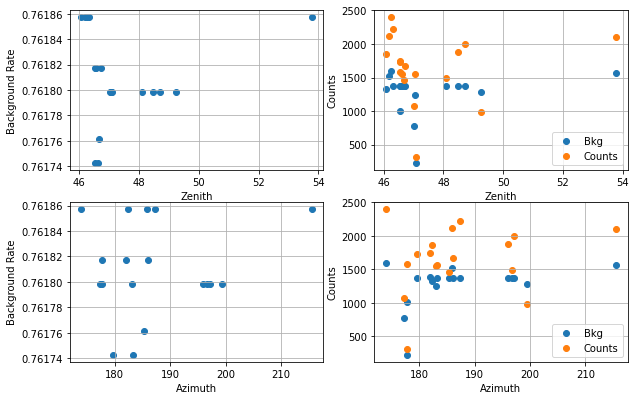

In [226]:
# Full Observations


a = list_of_datasets.info_table(cumulative=False)



zen_col = list(obs_table["ZEN_PNT"])
az_col = list(obs_table["AZ_PNT"])


from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
a["counts_rate"] = count_rate
a["excess_rate"] = excess_rate
a["background_rate"] = bkg_rate



fig = plt.figure(figsize = (10, 10))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")
plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()

a

In [227]:
# Models: Biggest Problem is that the model is the same for all dataset independent of the zenith angle

point_model = PointSpatialModel(lon_0="276.562 deg", lat_0="-14.825 deg")
#point_model.parameters.free_parameters.freeze_all()
point_model.lat_0.frozen = True
point_model.lon_0.frozen = True
#point_model.lon_0.scale = 1.2
"""
gaussian_model = GaussianSpatialModel(lon_0="276.562 deg", lat_0="-14.825 deg", sigma="0.07 deg",frame="icrs")
#gaussian_model.parameters.free_parameters.freeze_all()
gaussian_model.sigma.min = 0.1
"""
spatial_model = point_model


spectral_model = PowerLawSpectralModel(index=2.50, amplitude=3.2e-11 * u.Unit('1 / (cm2 s TeV)'), reference=1 * u.TeV)


model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    apply_irf={"exposure": True, "psf": True, "edisp": True},
)


for dataset in list_of_datasets:
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    bkg_model.spectral_model.norm.value = 1

models = Models([model, bkg_model])

# Joint Models
list_of_datasets.models = models.copy()

# Stacked Models
stacked.models = models.copy()

In [228]:
%%time
#Model Fitting
#Joint --> Not realistic to plot the Joint when you got so many runs
"""
fit_joint= Fit(list_of_datasets)
result_joint = fit_joint.run()
print(result_joint)
print(result_joint.parameters.to_table())
"""
# Stacked
fit_stacked= Fit(stacked)
result_stacked = fit_stacked.run()
print(result_stacked)
print(result_stacked.parameters.to_table())

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 106
	total stat : 138973.55

   name      value         unit         min        max    frozen   error  
--------- ----------- -------------- ---------- --------- ------ ---------
    index  3.1519e+01                       nan       nan  False 2.887e-04
amplitude -1.0490e-08 cm-2 s-1 TeV-1        nan       nan  False 2.032e-12
reference  1.0000e+00            TeV        nan       nan   True 0.000e+00
    lon_0  2.7656e+02            deg        nan       nan   True 0.000e+00
    lat_0 -1.4825e+01            deg -9.000e+01 9.000e+01   True 0.000e+00
CPU times: user 2.39 s, sys: 385 ms, total: 2.78 s
Wall time: 2.81 s


In [2]:
stacked.plot_residuals_spectral(region=on_region, method='diff/sqrt(model)')

NameError: name 'stacked' is not defined

In [ ]:
total_stat = result_joint.total_stat

for par in dataset.models.parameters:
    if par.frozen is False:
        profile=joint_fit.stat_profile(parameter=par)
        plt.plot(profile[f"{par.name}_scan"], profile["stat_scan"]-total_stat)
        plt.xlabel(f"{par.unit}")
        plt.ylabel("Delta TS")
        plt.title(f"{par.name}: {par.value} +- {par.error}")
        plt.show()
        plt.close()

In [206]:
# stacked.plot_residuals_spatial(vmin=-1, vmax=1);
# stacked.plot_residuals_spectral(region=region, method='diff/sqrt(model)')
"""
def plot_spectrum(model, result, label, color):
    spec = model.spectral_model
    energy_range = [0.2, 10] * u.TeV
    spec.plot(
        energy_range=energy_range, energy_power=2, label=label, color=color
    )
    spec.plot_error(energy_range=energy_range, energy_power=2, color=color)
plot_spectrum(stacked.models[0], result_stacked, label="stacked", color="tab:blue")
plot_spectrum(list_of_datasets.models[0], result_joint, label="joint", color="tab:orange")
plt.legend()
"""

'\ndef plot_spectrum(model, result, label, color):\n    spec = model.spectral_model\n    energy_range = [0.2, 10] * u.TeV\n    spec.plot(\n        energy_range=energy_range, energy_power=2, label=label, color=color\n    )\n    spec.plot_error(energy_range=energy_range, energy_power=2, color=color)\nplot_spectrum(stacked.models[0], result_stacked, label="stacked", color="tab:blue")\nplot_spectrum(list_of_datasets.models[0], result_joint, label="joint", color="tab:orange")\nplt.legend()\n'

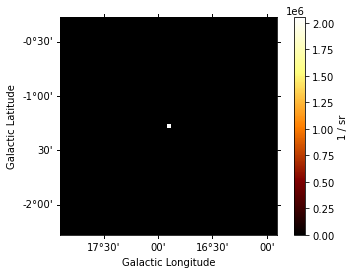

In [207]:
model_s = spatial_model
geom = WcsGeom.create(
    skydir=model.position, frame="galactic", width=(2, 2), binsz=0.02
)
ax = model_s.plot(geom=geom, add_cbar=True)

In [212]:
# SKYMAP

estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional=[],
    energy_edges=[0.2, 10.0, 20] * u.TeV,
    apply_mask_fit=True
)
result = estimator.run(stacked)

result = estimator.estimate_excess_map(stacked)

"""
estimator = TSMapEstimator(
    model,
    kernel_width="0.1 deg",
    energy_edges=[0.2, 10.0]* u.TeV,
)
maps = estimator.run(stacked)
"""

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


'\nestimator = TSMapEstimator(\n    model,\n    kernel_width="0.1 deg",\n    energy_edges=[0.2, 10.0]* u.TeV,\n)\nmaps = estimator.run(stacked)\n'

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7ff7693e00b8>)

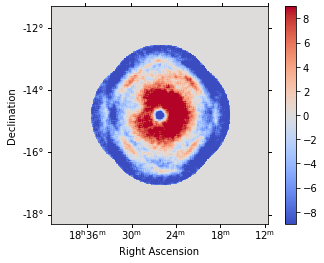

In [213]:
maps['sqrt_ts'].reduce(axis_name="energy").plot(cmap="coolwarm", add_cbar=True, vmin=-9, vmax=9)


The Map should display two sources. The correlation kind of smooth out these sources into one. Also, what's the deal with the blue hole??

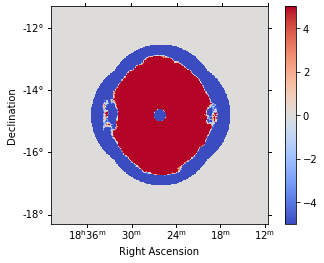

In [171]:

#counts : correlated counts map
#background : correlated background map
#excess : correlated excess map
#ts : TS map
#sqrt_ts : sqrt(delta TS), or Li-Ma significance map
#err : symmetric error map (from covariance)
#flux : flux map. An exposure map must be present in the dataset to compute flux map
#errn : negative error map
#errp : positive error map
#ul : upper limit map

result_d = result["sqrt_ts"].reduce(axis_name="energy")
result_d.plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5);

#result["background"].reduce(axis_name="energy").plot(cmap="coolwarm", add_cbar=True, vmin=-10, vmax=10)


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7ff898630518>)

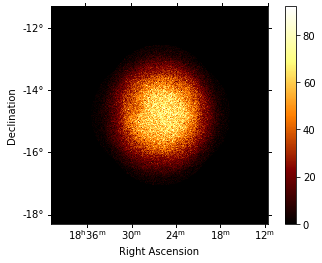

In [94]:
stacked.counts.smooth(0.00 * u.deg).sum_over_axes().plot(add_cbar=True)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7ff8e110a630>)

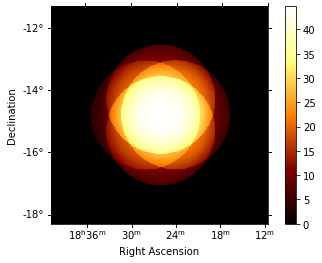

In [95]:
stacked.background.smooth(0.00 * u.deg).sum_over_axes().plot(add_cbar=True)

In [ ]:
e_edges = MapAxis.from_energy_bounds("0.200 TeV", "25 TeV", nbin=15).edges
fpe = FluxPointsEstimator(energy_edges=e_edges)

"""
# Joint
flux_points = fpe.run(datasets=list_of_datasets)
flux_points_datasets = FluxPointsDataset(data=flux_points, models=list_of_datasets.models)
"""

# Stacked
flux_points = fpe.run(datasets=[stacked])
flux_points_stacked = FluxPointsDataset(data=flux_points, models=stacked.models)




In [ ]:
#Joint & Stacked
"""
fig, axs = plt.figure(figsize = (20, 20))
plt.subplot(2, 2, 1)
flux_points_datasets.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Joint");
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
"""
flux_points_stacked.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Stacked");
plt.legend()
plt.grid()


In [ ]:
lc_maker_1d = LightCurveEstimator(energy_edges=[energy_axis.edges[0], energy_axis.edges[-1]], reoptimize=True)
lc_complete = lc_maker_1d.run(list_of_datasets)

plt.figure(figsize=(10,10))
ax = lc_complete.plot(marker="o", color="red", label=f"Light Curve")
plt.axhline(y=lc_complete.table["flux"].mean(), color="red", label="Mean Flux Line Gam")

lc_complete.table


In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2,1)
plt.errorbar(x=list(obs_table["ZEN_PNT"]),y=list(lc_complete.table["flux"]), yerr=list(lc_complete.table["flux_err"]), fmt="o")
plt.axhline(y=lc_complete.table["flux"].mean(), color="tab:blue")
plt.xlabel("Zenith")
plt.ylabel("Flux")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.errorbar(x=list(obs_table["AZ_PNT"]),y=list(lc_complete.table["flux"]), yerr=list(lc_complete.table["flux_err"]), fmt="o")
plt.axhline(y=lc_complete.table["flux"].mean(), color="tab:blue")
plt.xlabel("Azimuth")
plt.ylabel("Flux")
plt.legend()
plt.grid()

In [226]:
list_spectrum_datasets = Datasets()

joint_stacked = SpectrumDataset.create(e_reco=energy_axis, e_true=energy_axis_true, region=on_region, name="Spectrum_stacked from Joint")

for dataset in list_of_datasets:
    spectrum_dataset = dataset.to_spectrum_dataset(on_region=on_region, containment_correction=True, name = dataset.name)
    joint_stacked.stack(spectrum_dataset)
    list_spectrum_datasets.append(spectrum_dataset)
    
stack_stacked = stacked.to_spectrum_dataset(on_region=on_region, containment_correction=True, name = "Spectrum_stacked from Stack")



In [228]:
print("STACKED STACK")
print(stack_stacked)
print()
print("JOINT_STACKED")
print(joint_stacked)

STACKED STACK
SpectrumDataset
---------------

  Name                            : Spectrum_stacked from Stack 

  Total counts                    : 3952 
  Total background counts         : 2716.56
  Total excess counts             : 1235.44

  Predicted counts                : 2716.56
  Predicted background counts     : 2716.56
  Predicted excess counts         : nan

  Exposure min                    : 3.14e+05 m2 s
  Exposure max                    : 9.02e+09 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0



JOINT_STACKED
SpectrumDataset
---------------

  Name                            : Spectrum_stacked from Joint 

  Total counts                    : 3952 
  Total background counts         : 65.40
  Total excess counts             : 3886.60

  P